In [15]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit import execute, Aer
# from qc_grader import prepare_ex3, grade_ex3
import numpy as np
from heapq import nlargest


In [122]:

problem_set = [
    [["0", "2"], ["1", "0"], ["1", "2"], ["1", "3"], ["2", "0"], ["3", "3"]],
    [["0", "0"], ["0", "1"], ["1", "2"], ["2", "2"], ["3", "0"], ["3", "3"]],
    [["0", "0"], ["1", "1"], ["1", "3"], ["2", "0"], ["3", "2"], ["3", "3"]],
    [["0", "0"], ["0", "1"], ["1", "1"], ["1", "3"], ["3", "2"], ["3", "3"]],
    [["0", "2"], ["1", "0"], ["1", "3"], ["2", "0"], ["3", "2"], ["3", "3"]],
    [["1", "1"], ["1", "2"], ["2", "0"], ["2", "1"], ["3", "1"], ["3", "3"]],
    [["0", "2"], ["0", "3"], ["1", "2"], ["2", "0"], ["2", "1"], ["3", "3"]],
    [["0", "0"], ["0", "3"], ["1", "2"], ["2", "2"], ["2", "3"], ["3", "0"]],
    [["0", "3"], ["1", "1"], ["1", "2"], ["2", "0"], ["2", "1"], ["3", "3"]],
    [["0", "0"], ["0", "1"], ["1", "3"], ["2", "1"], ["2", "3"], ["3", "0"]],
    [["0", "1"], ["0", "3"], ["1", "2"], ["1", "3"], ["2", "0"], ["3", "2"]],
    [["0", "0"], ["1", "3"], ["2", "0"], ["2", "1"], ["2", "3"], ["3", "1"]],
    [["0", "1"], ["0", "2"], ["1", "0"], ["1", "2"], ["2", "2"], ["2", "3"]],
    [["0", "3"], ["1", "0"], ["1", "3"], ["2", "1"], ["2", "2"], ["3", "0"]],
    [["0", "2"], ["0", "3"], ["1", "2"], ["2", "3"], ["3", "0"], ["3", "1"]],
    [["0", "1"], ["1", "0"], ["1", "2"], ["2", "2"], ["3", "0"], ["3", "1"]],
]




def mark_address(qc, qubits, index):

    if index not in range(16):
        raise ValueError("index must be in range(16)")
    
    #if len(qubits) != 4:
    #    raise ValueError("qubits must have length of 4")
    
    # Convert index to a binary string
    bin_str = f'{index:01b}'

    for i in range(len(qubits)):
        if bin_str[i] == "0":
            qc.x(qubits[i])

    return qc


def qft_dagger(n):
    """n-qubit QFTdagger the first n qubits in circ"""
    circ = QuantumCircuit(n)
    # Don't forget the Swaps!
    for qubit in range(n // 2):
        circ.swap(qubit, n - qubit - 1)
    for j in range(n):
        for m in range(j):
            circ.cp(-np.pi / float(2 ** (j - m)), m, j)
        circ.h(j)

    qft_dag = circ.to_gate()
    qft_dag.name = "$QFT_dag$"
    return qft_dag


def get_game_logic_gate(qr_shot_h, qr_shot_v, qr_addres, qr_clustr, qr_extra, ps):
    
    qc = QuantumCircuit(qr_shot_h, qr_shot_v, qr_addres, qr_clustr, qr_extra)

    for p, puzzle in enumerate(ps): # for each puzzle

        puzzle = np.array(puzzle, int) # convert to int
        # Mark the puzzle's address (p):
        qc = mark_address(qc, qr_addres, p)

        for c, (h, v) in enumerate(puzzle): # for each position pair in puzzle
            # Control cluster c with address and the puzzle's horizontal number
            qc.mct(qr_addres[:] + [qr_shot_h[h]], qr_clustr[c], qr_extra, mode="v-chain")
            qc.mct(qr_addres[:] + [qr_shot_v[v]], qr_clustr[c], qr_extra, mode="v-chain")

        # Unmark the puzzles's address:
        qc = mark_address(qc, qr_addres, p)
    # Convert to gate and return
    game_logic = qc.to_gate()
    game_logic.name = "GameLogic"
    return game_logic


def oracle(qc, qr_shot_h, qr_shot_v, qr_addres, qr_clustr, qr_countr, qr_anclla, qr_extra, ps):

    # Step 1: Enter logic for the game
    game_logic_gate = get_game_logic_gate(qr_shot_h, qr_shot_v, qr_addres, qr_clustr, qr_extra, ps)
    game_qubits = qr_shot_h[:] + qr_shot_v[:] + qr_addres[:] + qr_clustr[:] + qr_extra[:]

    qc.append(game_logic_gate, game_qubits)

    qc.barrier()

    # Step 2: Append counting logic
    qc.h(qr_countr)

    for q_shot in (qr_shot_h[:] + qr_shot_v[:]):
        for i, q_countr in enumerate(qr_countr):
            qc.cp(np.pi / 2 ** (len(qr_countr) - i - 1), q_shot, q_countr)

    qc.append(qft_dagger(len(qr_countr)), qr_countr)

    # Mark the desired state: 3 or less = 00**
    qc.x(qr_countr[2:])

    qc.barrier()

    # Step 3: Check for the solution
    qc.mct(qr_clustr[:] + qr_countr[2:], qr_anclla, qr_extra, mode="v-chain")
    qc.barrier()
    
    # Step 4: Uncompute counting circuit
    # Unmark the desired state
    qc.x(qr_countr[2:])

    # Uncompute counting logic
    qc.append(qft_dagger(len(qr_countr)).inverse(), qr_countr)

    for q_shot in (qr_shot_h[:] + qr_shot_v[:]):
        for i, q_countr in enumerate(qr_countr):
            qc.cp(np.pi / 2 ** (len(qr_countr) - i - 1), q_shot, q_countr)

    qc.h(qr_countr)

    qc.barrier()

    # Step 5: Uncompute game logic
    qc.append(game_logic_gate.inverse(), game_qubits)
        
    qc.barrier()
    
    return qc

def diffusion(qc, qubits, qr_extr):
    qc.h(qubits)
    qc.x(qubits)
    qc.h(qubits[-1])
    qc.mct(qubits[:-1], qubits[-1], qr_extr, mode="recursion")
    qc.h(qubits[-1])
    qc.x(qubits)
    qc.h(qubits)
    
    qc.barrier()

    return qc


def week3_ans_func(problem_set):
    # Build your quantum circuit here
    # In addition, please make it a function that can solve the 
    # problem even with different inputs (problem_set). We do validation with different inputs.
    # problem_set = problem_set[8:12]
    problem_set = [problem_set[0], problem_set[1]]

    # 4 + 4 (shot options) + 6 (clusters) + 4 (address) + 3 (counting) + 1 (ancilla) = 22, 6 extra! 
    qr_shot_h = QuantumRegister(4, name="horz shots")
    qr_shot_v = QuantumRegister(4, name="vert shots")
    qr_clustr = QuantumRegister(6, name="clusters")
    qr_addres = QuantumRegister(1, name="address")
    qr_countr = QuantumRegister(3, name="counting")
    qr_anclla = QuantumRegister(1, name="ancl")
    qr_extra = QuantumRegister(6, name="extra")

    
    cr_shots = ClassicalRegister(8)
    cr_count = ClassicalRegister(3)
    cr_address = ClassicalRegister(2)

    qc = QuantumCircuit(qr_shot_h, qr_shot_v, qr_addres, qr_clustr, qr_countr, qr_anclla, qr_extra, cr_address)
    
    qc = QuantumCircuit(qr_shot_h, qr_shot_v, qr_addres, qr_clustr, qr_countr, qr_anclla, qr_extra, cr_shots)

    # Set cluster status to 0
    # No code required

    # Prepare ancilla
    qc.x(qr_anclla)
    qc.h(qr_anclla)

    # Put solution into superposition
    qc.h(qr_shot_h[:] + qr_shot_v[:] + qr_addres[:])

    qc.barrier()
    
    # Code for Grover's algorithm with iterations = 1 will be as follows.
    for i in range(1):
        oracle(qc, qr_shot_h, qr_shot_v, qr_addres, qr_clustr, qr_countr, qr_anclla, qr_extra, problem_set)
        diffusion(qc, qr_shot_h[:] + qr_shot_v[:] + qr_addres[:], qr_extra) # Maybe just address?
        # diffusion(qc, qr_addres, qr_extra)

    qc.measure(qr_shot_h[:] + qr_shot_v[:], cr_shots)
    #qc.measure(qr_addres, cr_address)
    qc = qc.reverse_bits()

    return qc

qc = week3_ans_func(problem_set)
# qc.draw(output="mpl")
# New idea: 6 bits for state, 8 bits for shots, problem logic is programmed into oracle? Main question: how to scale?

In [123]:
import time

backend = Aer.get_backend("qasm_simulator")
tic = time.perf_counter()
job = execute(
    qc,
    backend=backend,
    shots=20000,
    backend_options={"fusion_enable": True},
)
toc = time.perf_counter()

print(f"Circuit executed in {toc - tic:0.4f} seconds")

result = job.result()
count = result.get_counts()

for k, v in count.items():
    print(k, v)


Circuit executed in 0.0366 seconds
00000000 51
00000001 84
00010000 73
00010001 96
00010010 82
00010011 79
00010100 79
00010101 79
00010110 83
00010111 69
00011000 82
00011001 69
00011010 90
00011011 65
00011100 72
00011101 66
00011110 60
00011111 72
00000010 78
00100000 71
00100001 92
00100010 105
00100011 78
00100100 93
00100101 89
00100110 93
00100111 61
00101000 82
00101001 93
00101010 85
00101011 49
00101100 77
00101101 73
00101110 86
00101111 80
00000011 85
00110000 92
00110001 73
00110010 82
00110011 67
00110100 94
00110101 78
00110110 77
00110111 80
00111000 99
00111001 84
00111010 65
00111011 84
00111100 71
00111101 75
00111110 59
00111111 79
00000100 93
01000000 66
01000001 76
01000010 105
01000011 73
01000100 76
01000101 69
01000110 87
01000111 68
01001000 95
01001001 89
01001010 92
01001011 74
01001100 82
01001101 67
01001110 67
01001111 78
00000101 75
01010000 82
01010001 86
01010010 100
01010011 80
01010100 75
01010101 54
01010110 72
01010111 82
01011000 69
01011001 64
01

0 0 0 2
0 1 1 0
0 2 1 2
0 3 1 3
0 4 2 0
0 5 3 3
1 0 0 0
1 1 0 1
1 2 1 2
1 3 2 2
1 4 3 0
1 5 3 3


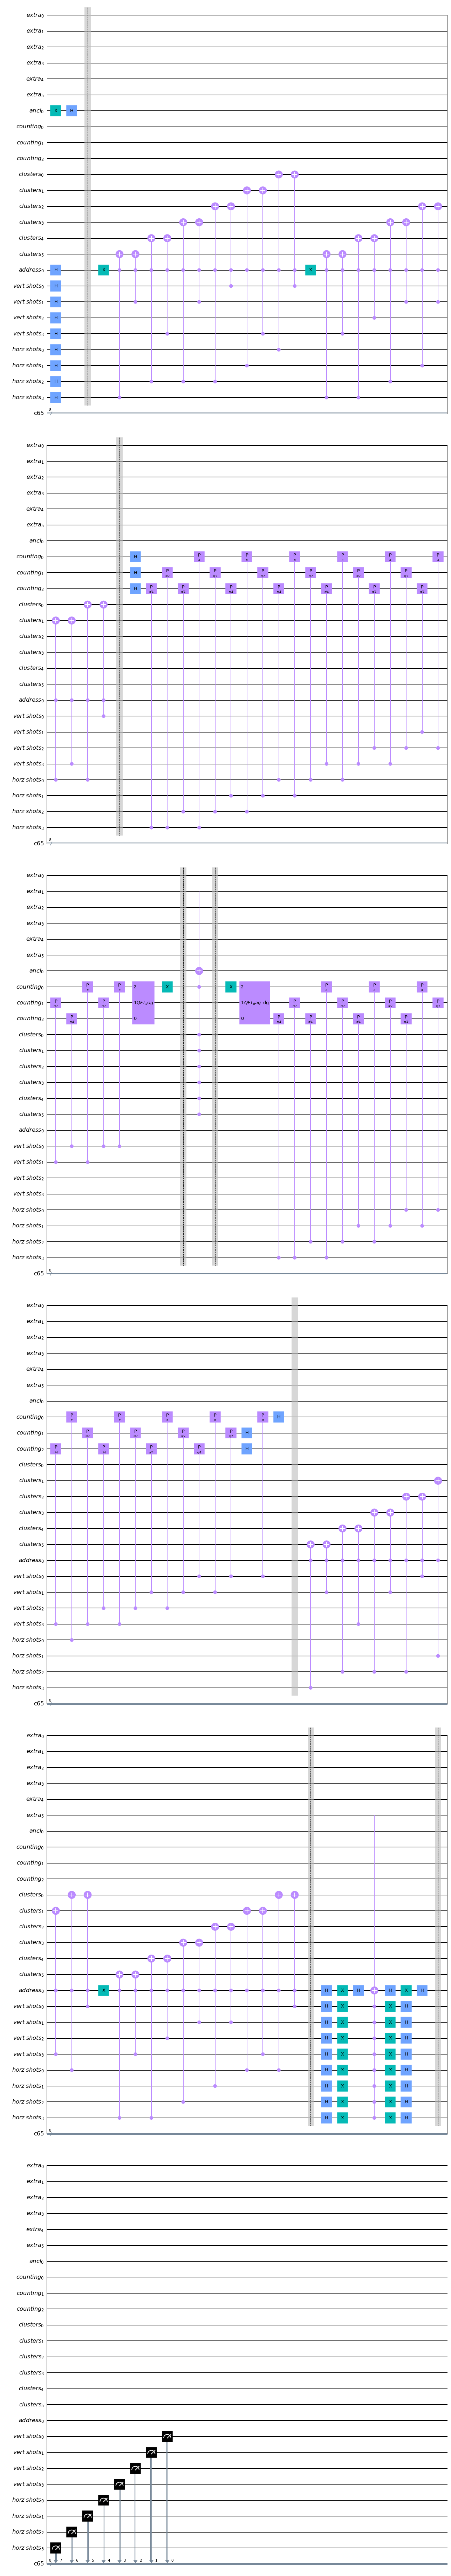

In [120]:
ps = [problem_set[0], problem_set[1]]

for p, puzzle in enumerate(ps): # for each puzzle
        puzzle = np.array(puzzle, int) # convert to int
        
        # Mark the puzzle's address (p):
        #qc = mark_address(qc, qr_addres, p)

        for c, (h, v) in enumerate(puzzle): 
            print(p, c, h, v)

qc.draw(output="mpl")

In [ ]:
#